In [2]:
# Imports and setup.
from nerf_grasping import grasp_opt, grasp_utils, mesh_utils
import lietorch
import nerf
import numpy as np
import os
import pypoisson
import scipy.spatial
import torch
import trimesh

from matplotlib import pyplot as plt

# nerf_shared requires us to default to cuda tensors.
torch.set_default_tensor_type(torch.cuda.FloatTensor)

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [4]:
parser = nerf.utils.get_config_parser()
opt = parser.parse_args([
    'torch-ngp/data/isaac_banana/', '--workspace', 'torch-ngp/logs/banana',
    '--bound', '2', '--scale', '1'
])
print(opt)

nerf.utils.seed_everything(opt.seed)
model = grasp_utils.load_nerf(opt)

# Setup params for grasp optimization.
num_grasps = 100
n_f = 3
residual_dirs = True
num_rounds = 5

# Initialize points more-or-less spread apart.
grasp_points = 1. * torch.tensor([[0.09, 0.09, -0.025], [-0.09, 0.09, 0.025],
                                  [0, -0.125, 0]]).reshape(1, 3, 3)
grasp_dirs = torch.zeros_like(grasp_points)

# Convert these to mean/covariance for CEM.
mu_0 = torch.cat([grasp_points, grasp_dirs], dim=-1).reshape(-1)
Sigma_0 = 25 * torch.diag(
    torch.cat(
        [torch.tensor([5e-3, 5e-3, 5e-3, 1e-3, 1e-3, 1e-3]) for _ in range(3)]))

# Setup CEM cost.
cem_cost = lambda x: grasp_opt.grasp_cost(
    x, n_f, model, residual_dirs=residual_dirs)

mus = []
mus.append(mu_0)
mu_f = mu_0
Sigma_f = Sigma_0

# Optimize points with CEM.
with torch.no_grad():
    for ii in range(num_rounds):
        mu_f, Sigma_f, cost_history = grasp_opt.optimize_cem(cem_cost,
                                                             mu_f,
                                                             Sigma_f,
                                                             num_iters=1,
                                                             elite_frac=.25,
                                                             num_samples=1000)
        mus.append(mu_f)

Namespace(H=800, W=800, bound=2.0, cuda_ray=False, ff=False, fovy=90, fp16=False, gui=False, max_ray_batch=4096, max_spp=64, mode='colmap', num_rays=4096, num_steps=128, opt_poses=False, path='torch-ngp/data/isaac_banana/', preload=False, radius=5, rot_noise=0.0, scale=1.0, seed=0, tcnn=False, test=False, trans_noise=0.0, upsample_steps=128, workspace='torch-ngp/logs/banana')


[INFO] Trainer: ngp | 2022-06-08_12-51-11 | cuda:0 | fp32 | torch-ngp/logs/banana

[INFO] #parameters: 12667002

[INFO] Loading latest checkpoint ...

[INFO] Latest checkpoint is torch-ngp/logs/banana/checkpoints/ngp_ep0200.pth.tar

[INFO] loaded model.

[WARN] Failed to load optimizer, use default.

[WARN] Failed to load scheduler, use default.

[INFO] loaded scaler.

tensor(-0.0044, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor(-0.0033, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor(-0.0046, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor(-0.0042, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor(-0.0050, dtype=torch.float64) tensor(inf, dtype=torch.float64)


In [3]:
T = np.eye(4)
pose = np.array([
    1.2108e-04, 5.0580e-05, 2.7067e-03, -6.7140e-03, -9.7980e-03, 4.5278e-05,
    9.9993e-01
])

R = scipy.spatial.transform.Rotation.from_euler('Y', [-np.pi / 2]).as_matrix()
R = R @ scipy.spatial.transform.Rotation.from_euler('X',
                                                    [-np.pi / 2]).as_matrix()
T[:3, :3] = R
T[:3, -1] = pose[:3]

print(R @ np.eye(3))

gt_mesh = trimesh.load('assets/objects/meshes/banana/textured.obj',
                       force='mesh')
gt_mesh.apply_transform(trimesh.transformations.translation_matrix(pose[:3]))
gt_mesh.apply_transform(T)
gt_mesh.show()

[[[ 2.22044605e-16  1.00000000e+00 -2.22044605e-16]
  [ 0.00000000e+00  2.22044605e-16  1.00000000e+00]
  [ 1.00000000e+00 -2.22044605e-16  4.93038066e-32]]]


/home/pculbert/miniconda3/envs/nerf_grasping/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [51]:
rays_o = np.random.randn(5, 3)
rays_d = -rays_o

gt_mesh.ray.intersects_location(rays_o, rays_d, multiple_hits=False)

(array([[-0.00852767,  0.01430454, -0.03586976],
        [ 0.01012516,  0.00588075, -0.0055801 ],
        [ 0.00115488,  0.00747355, -0.00506434]]),
 array([2, 3, 4]),
 array([8599, 5923, 3499], dtype=int32))

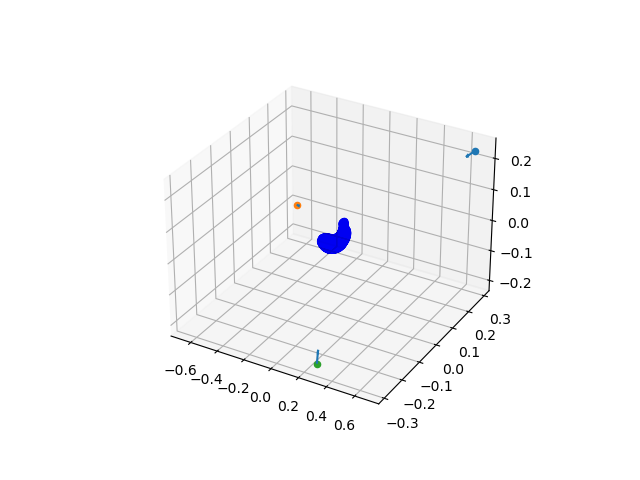

In [9]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mu_np = mus[-1].cpu().detach().reshape(3, 6)
rays_o, rays_d = mu_np[:, :3], mu_np[:, 3:]

rays_d = torch.reshape(rays_d, [-1, 3]).float()
rays_d = lietorch.SO3.exp(rays_d).matrix()[:, :3, :3] @ -rays_o.unsqueeze(-1)
rays_d = rays_d.reshape(-1, 3)

for ii in range(rays_o.shape[0]):
    ax.scatter(rays_o[ii, 0], rays_o[ii, 1], rays_o[ii, 2])
    ax.quiver(*[rays_o[ii, jj] for jj in range(3)],
              *[rays_d[ii, jj] for jj in range(3)],
              length=0.05,
              normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)],
           c='blue',
           alpha=0.025)

plt.show()

In [22]:
sample_inds = np.random.choice(np.arange(gt_mesh.triangles_center.shape[0]),
                               size=100)
sample_pts = gt_mesh.triangles_center[sample_inds]

rhos, grads = grasp_utils.est_grads_vals(
    model,
    torch.from_numpy(sample_pts).float().reshape(1, -1, 3).cuda())

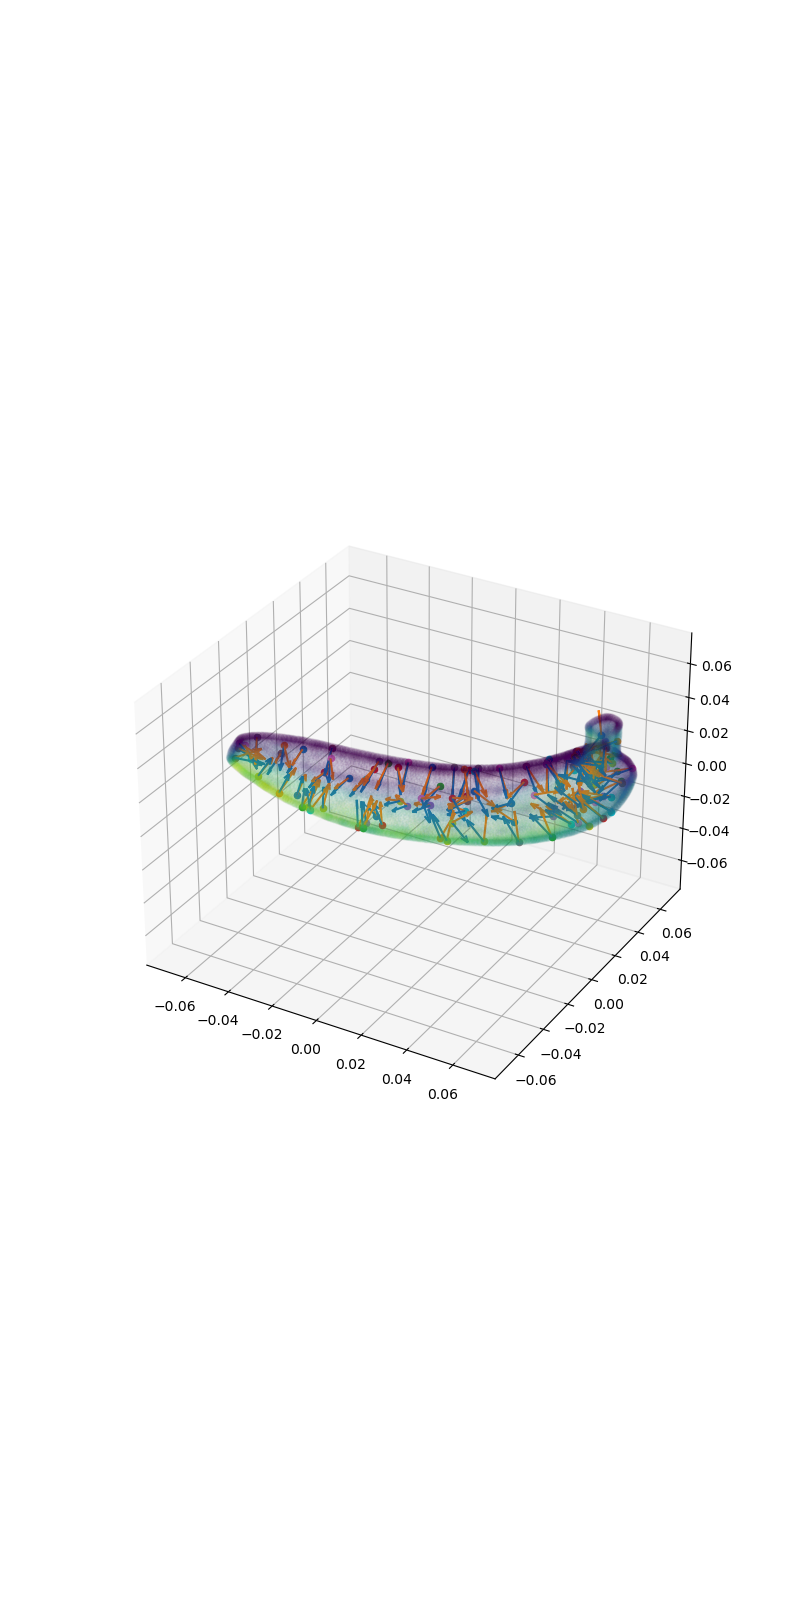

In [24]:
# np.random.seed(2895)
# sample_inds = np.random.choice(np.arange(gt_mesh.triangles_center.shape[0]),
#                                size=10)
sample_pts = gt_mesh.triangles_center[sample_inds]

rhos, grads = grasp_utils.est_grads_vals(
    model,
    torch.from_numpy(sample_pts).float().reshape(1, -1, 3).cuda(),
    sigma=5e-3,
    num_samples=1000,
    method='gaussian')

surface_rhos = model.density(
    torch.from_numpy(gt_mesh.triangles_center).float().cuda())

plt.close('all')
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(projection='3d')
grads = grads / torch.linalg.norm(grads, dim=-1, keepdim=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)],
           c=surface_rhos.cpu().detach().numpy(),
           alpha=0.025)

for ii in range(sample_pts.shape[0]):
    ax.scatter(sample_pts[ii, 0], sample_pts[ii, 1], sample_pts[ii, 2])
    ax.quiver(*[sample_pts[ii, jj] for jj in range(3)],
              *[grads[0, ii, jj].cpu().detach() for jj in range(3)],
              length=0.015,
              normalize=True,
              color='C0')

    ax.quiver(*[sample_pts[ii, jj] for jj in range(3)],
              *[-gt_mesh.face_normals[sample_inds[ii], jj] for jj in range(3)],
              length=0.015,
              normalize=True,
              color='C1')

ax.set_xlim([-0.075, 0.075])
ax.set_ylim([-0.075, 0.075])
ax.set_zlim([-0.075, 0.075])

plt.show()

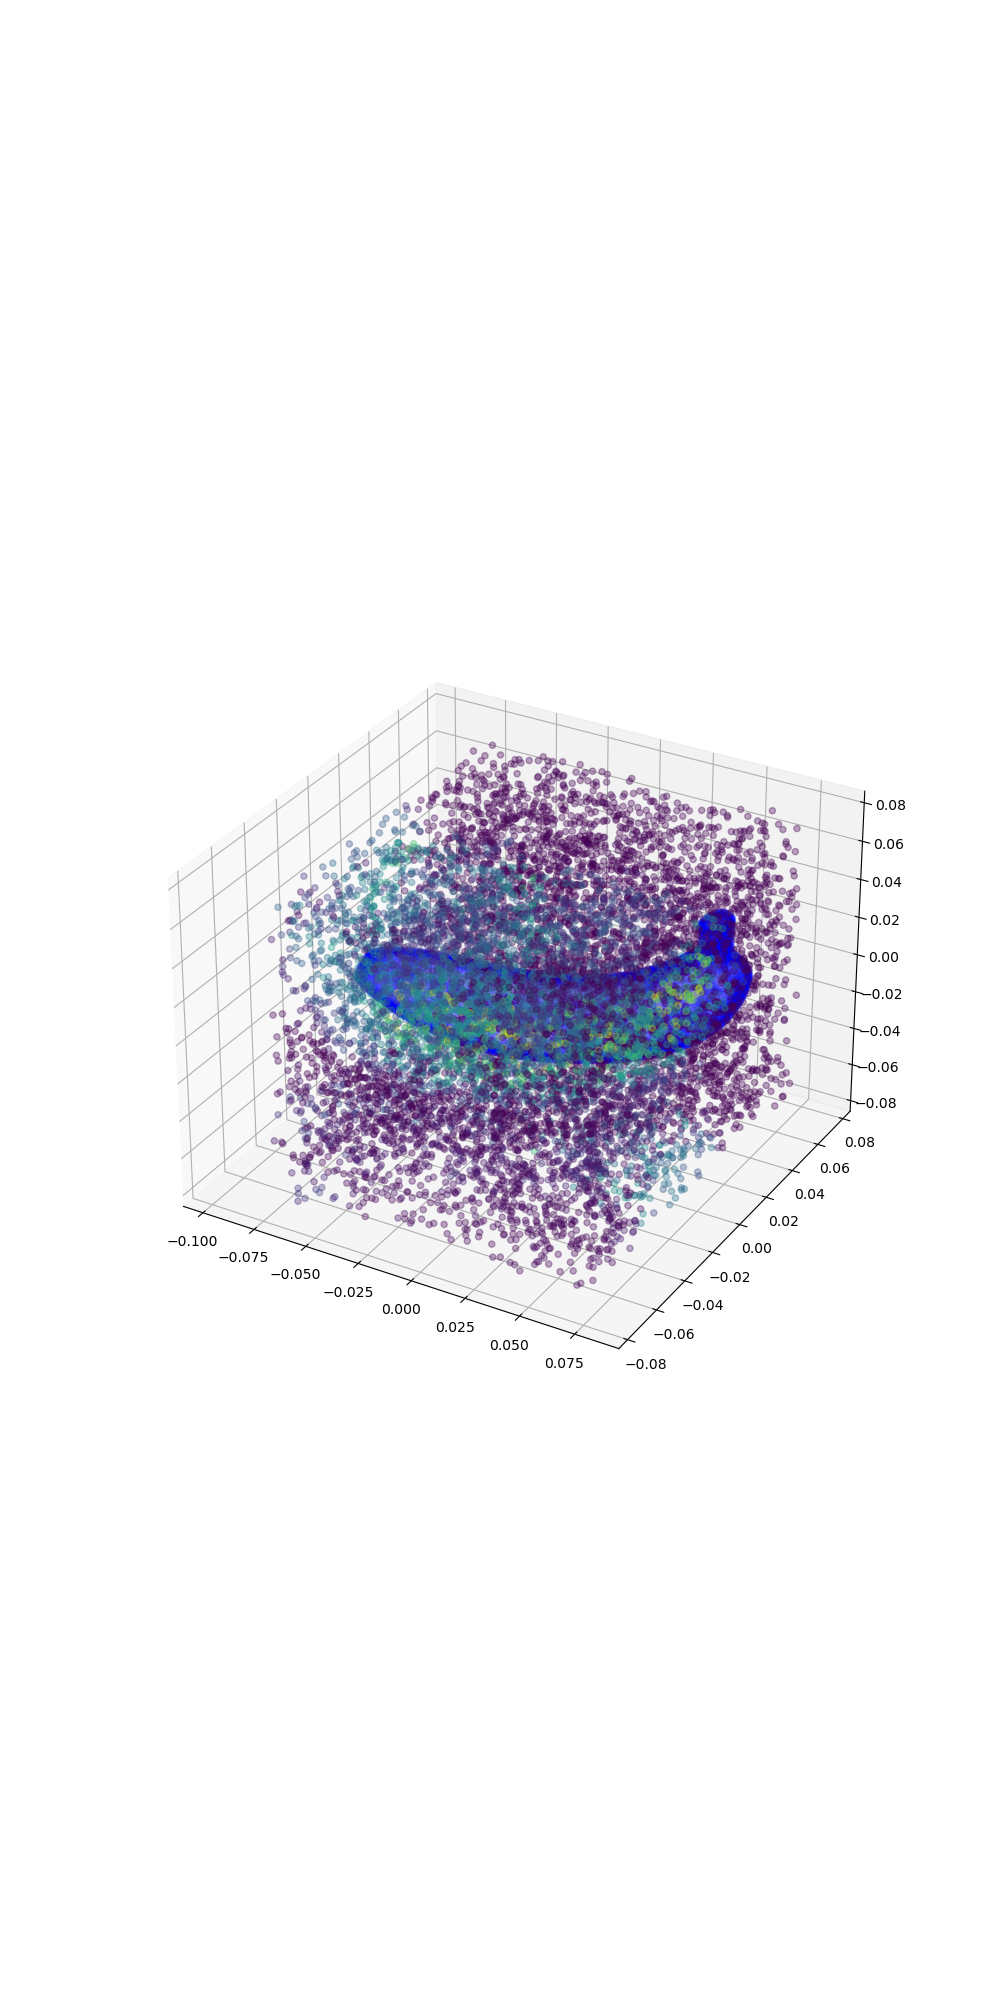

In [19]:
points = 0.15 * (torch.rand(10000, 3) - 0.5).cuda()
rhos = model.density(points)

plt.close('all')
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(projection='3d')

ax.scatter(*[points.cpu().numpy()[:, ii] for ii in range(3)],
           c=rhos.cpu().detach().numpy(),
           alpha=0.35)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)],
           c='blue',
           alpha=0.05)

In [11]:
isinstance(gt_mesh, trimesh.Trimesh)

True